## HCA Data Science I - Coding Challenge
### Benjamin N. Conrad, 7/20/2021


----
## Scenario
A colleague has connected with our team because they want to apply data science to their work on ensuring excellent care for diabetes patients. You have been asked to do initial exploratory data analysis and modeling to test the feasibility of proceeding with this initiative.

---
## Part 1 – Explore the problem
1. How many rows and columns are in the data set?
2. How many men are represented in the data versus women?
3. What percentage of the patients are African American?
4. What is the approximate average age of female and male patients in the data set?
5. Which features have more than 50% missing data?
6. Write a function to remove features from the data set that have a high proportion of missing values.
7. The business owner you are collaborating with is concerned about patients who are readmitted within 30 days. She wants to know which medical specialty has the biggest problem with these readmissions. What do you tell her?

## Part 2 – Build a model
1. Build a predictive model to identify patients at risk of readmitting within 30 days.
2. Evaluate your model.

## Part 3 – Communicate findings
The business owner sends you an email asking for an update on the project. What is your response?

---

### 0.1 Set up environment and load data

In [1]:
# Import packages and functions
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

### 1.1 How many rows and columns are in the data set?

In [2]:
# Load data
# Specify "?" as a null value)
df = pd.read_csv('data/diabetes_data.csv',na_values=['?'],low_memory=False)

# Report number of rows and columns
print(f'The dataset has {df.shape[0]} rows.')
print(f'The dataset has {df.shape[1]} columns.')

The dataset has 101766 rows.
The dataset has 50 columns.


In [3]:
# Check dataset structure
df.head()

,encounter_id,patient_nbr,race,gender,weight,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,payer_code,...,glyburide-metformin,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admit_date,birth_date
0,2278392,8222157,Caucasian,Female,NaN,6,25,1,1,NaN,...,No,No,No,No,No,No,No,NO,2002-10-22 06:30:00,1996-07-29 14:28:00
1,149190,55629189,Caucasian,Female,NaN,1,1,7,3,NaN,...,No,No,No,No,No,Ch,Yes,>30,2004-07-24 08:35:00,1985-09-19 11:19:00
2,64410,86047875,AfricanAmerican,Female,NaN,1,1,7,2,NaN,...,No,No,No,No,No,No,Yes,NO,2005-11-30 06:35:00,1983-07-14 07:22:00
3,500364,82442376,Caucasian,Male,NaN,1,1,7,2,NaN,...,No,No,No,No,No,Ch,Yes,NO,2003-05-26 00:32:00,1968-04-05 23:51:00
4,16680,42519267,Caucasian,Male,NaN,1,1,7,1,NaN,...,No,No,No,No,No,Ch,Yes,NO,2004-04-25 04:04:00,1957-11-18 20:30:00


### I noticed that there are some patients with multiple entries. Let's remove those to prevent a bias towards their particular medical profiles. This will also allow us to be more specific about predicting the readmission risk of a *new* patient. 

In [4]:
# Check for unique patients
vc = df['patient_nbr'].value_counts()
print(f'{vc[vc == 1].sum()} patients with 1 entry')
print(f'{vc[(vc > 1) & (vc < 3)].sum()} patients with 2 entries')
print(f'{vc[(vc > 2) & (vc < 10)].sum()} patients with 3-10 entries')
print(f'{vc[(vc >= 10)].sum()} patients with 10 or more entries')

54745 patients with 1 entry
20868 patients with 2 entries
24296 patients with 3-10 entries
1857 patients with 10 or more entries


In [5]:
# Drop additional instances of patients
# Sort by patient number
df.sort_values('patient_nbr', inplace = True)
 
# Drop rows if duplicate values
df.drop_duplicates(subset ="patient_nbr",
                     keep = 'first', inplace = True)

### 1.2 How many men are represented in the data versus women?

The dataset has 33490 males
The dataset has 38025 females


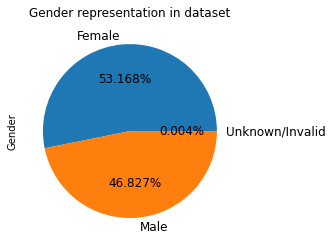

In [6]:
# Print the total number of each gender
print(f'The dataset has {len(df[df.gender == "Male"])} males')
print(f'The dataset has {len(df[df.gender == "Female"])} females')

# Use value_counts and pie chart to show the representation of each value of "gender"
plot = df['gender'].value_counts(dropna=False).plot(kind='pie', autopct='%1.3f%%', fontsize=12,
                                        title='Gender representation in dataset',
                                        ylabel='Gender')

### 1.3 What percentage of the patients are African American?

The dataset is 18.04% African American (including null entries).


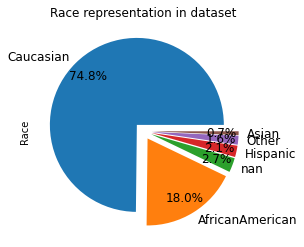

In [7]:
# Print the percentage of African Americans in the dataset
# Use value_counts and "normalize" to indicate the proportion of unique values in "race" column
race = df['race'].value_counts(normalize=True,dropna=False)
print(f'The dataset is {np.round(100 * race.at["AfricanAmerican"],decimals=3)}% African American (including null entries).')

# Plot pie chart of race representation
race = df['race'].value_counts(normalize=True,dropna=False)
plot = race.plot(kind='pie',autopct='%1.1f%%', fontsize=12,
                 title='Race representation in dataset',
                 ylabel='Race',explode=([0.1] * len(race)),
                 pctdistance=0.8)

### 1.4 What is the approximate average age of female and male patients in the data set?

On average, females are 66.79 years old.
On average, males are 65.1 years old.


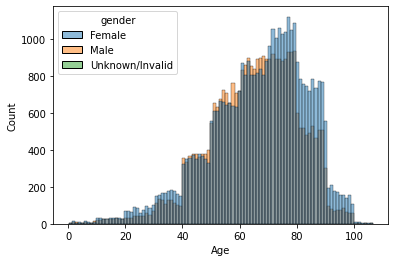

In [8]:
# Don't have age value, so need to calculate it based on [admission data - birth date]
# First convert dates to datetime format
df['admit_date'] = pd.to_datetime(df['admit_date'])
df['birth_date'] = pd.to_datetime(df['birth_date'])

# Compute difference in years
df['Age'] = (df.admit_date - df.birth_date).dt.days / 365.25

# Calculate average age of females and males
gender_age = df.groupby('gender')['Age'].mean()

# Print approximate averages
print(f'On average, females are {np.round(gender_age.at["Female"],decimals=2)} years old.')
print(f'On average, males are {np.round(gender_age.at["Male"],decimals=2)} years old.')

# Plot histogram of ages using seaborn
plot = sns.histplot(data=df,x='Age',hue='gender')

### 1.5 Which features have more than 50% missing data?

In [9]:
# Report columns (i.e., features) where the missing proportion is greater than 0.50
thresh = 0.50;
missing = df.columns[df.isnull().mean() > thresh]
print(f'The following features have more than {100*thresh}% missing data: {list(missing)}')

The following features have more than 50.0% missing data: ['weight']


### 1.6 Write a function to remove features from the data set that have a high proportion of missing values.

In [10]:
# Function that returns new dataframe, including only columns with less than thresh missing values
def rm_missing(df,thresh):
    df_out = df[df.columns[df.isnull().mean() < thresh]]
    return df_out

# Run function, removing columns with >= 20% missing values 
df_reduced = rm_missing(df,0.20)
df_reduced.head(-1)

,encounter_id,patient_nbr,race,gender,admission_type_id,discharge_disposition_id,admission_source_id,time_in_hospital,num_lab_procedures,num_procedures,...,glipizide-metformin,glimepiride-pioglitazone,metformin-rosiglitazone,metformin-pioglitazone,change,diabetesMed,readmitted,admit_date,birth_date,Age
4267,24437208,135,Caucasian,Female,2,1,1,8,77,6,...,No,No,No,No,Ch,Yes,<30,2006-03-29 15:44:00,1952-09-25 22:21:00,53.503080
5827,29758806,378,Caucasian,Female,3,1,1,2,49,1,...,No,No,No,No,No,No,NO,2000-06-27 03:13:00,1947-01-22 16:37:00,53.426420
67608,189899286,729,Caucasian,Female,1,3,7,4,68,2,...,No,No,No,No,No,Yes,NO,2003-02-17 04:58:00,1914-06-24 03:48:00,88.651608
17494,64331490,774,Caucasian,Female,1,1,7,3,46,0,...,No,No,No,No,Ch,Yes,NO,2006-05-30 11:21:00,1924-06-21 08:06:00,81.938398
2270,14824206,927,AfricanAmerican,Female,1,1,7,5,49,0,...,No,No,No,No,No,Yes,NO,2002-04-27 05:51:00,1965-11-14 13:17:00,36.446270
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95283,359725880,189349430,Asian,Female,1,1,7,1,31,0,...,No,No,No,No,No,Yes,NO,2002-01-18 06:49:00,1931-10-31 18:15:00,70.214921
99863,418513058,189351095,Caucasian,Female,1,1,7,1,73,1,...,No,No,No,No,No,No,NO,1999-12-07 03:27:00,1914-05-10 08:33:00,85.574264
95282,359719064,189365864,Other,Male,1,1,7,3,56,1,...,No,No,No,No,No,Yes,NO,2004-04-29 22:15:00,1942-07-13 10:01:00,61.796030
93651,338462954,189445127,Caucasian,Female,1,1,7,3,39,0,...,No,No,No,No,Ch,Yes,NO,2008-12-12 17:48:00,1922-03-05 05:48:00,86.773443


### 1.7 The business owner you are collaborating with is concerned about patients who are readmitted within 30 days. She wants to know which medical specialty has the biggest problem with these readmissions. What do you tell her?

In [11]:
# Get total proportion of unique values of "medical_specialty", including NaN entries
med_specs = df.medical_specialty.value_counts(normalize=True,dropna=False)
perc_nan = np.round(med_specs.at[float("NaN")] * 100,decimals=1)

# Report the percentage that are NaN
print(f'The medical specialty is missing for approximately {perc_nan}% of all patient entries.')

# Now calculate the number of readmitted patients, and the percentage of those that are missing
readmit = df[df['readmitted'] == '<30']
readmit_nan = readmit['medical_specialty'].isnull().sum()
print(f'And of those readmitted, {np.round(100 * readmit_nan/len(readmit),decimals=1)}% do not have a medical speciality listed.')

The medical specialty is missing for approximately 48.2% of all patient entries.
And of those readmitted, 50.1% do not have a medical speciality listed.


### Answer:
### *Unfortunately, the "medical specialty" is missing in over 48% of the dataset. And further, of those patients readmitted within 30 days, more than half do not have a speciality listed. Thus, unless we can confirm the speciality entries are truly "missing at random," we cannot make a valid comparison across specialities. For instance, if the reporting of specialty is related to the speciality itself, it could bias our conclusions.*
---

## Modeling readmission risk

### 2.1 Build a predictive model to identify patients at risk of readmitting within 30 days.

### Feature engineering
1. Remove some subject-specific identifier variables. Also fill some missing entries so they can contribute to the model.
2. Run PCA on the diagnostic codes to reduce dimensionality of features. This is intended as a demonstration of this method and should make model training more efficient. However, it will be make interpretability of the particular diagnostic code features much more difficult. Also note, to improve generalizability, it is preferable to do PCA on ONLY the training set, and then apply to the test set. 
3. One-hot encoding of categorical variables and standardization (to aid in feature importance interpretability)
4. Make predicted variable binary (readmit <30 days or not)

In [12]:
# Set the predictor data (X)
X = df_reduced.copy()

# Drop the outcome variable, and unique identifier fields
X = X.drop(['readmitted','encounter_id','patient_nbr','admit_date','birth_date'],axis=1)

# Set missing values to specifically missing
vars_fill = ['race', 'diag_1','diag_2','diag_3']
X[vars_fill] = X[vars_fill].fillna(value='Unknown')

# Convert the id code variables to object format (because these are categorical codes, rather than numeric)
cols_to_obj = ['admission_type_id','admission_source_id','discharge_disposition_id']
X[cols_to_obj] = X[cols_to_obj].astype(object)

In [13]:
# PCA of diagnostic codes
# Remove diagnostic codes from dataframe
diag_list = ['diag_1','diag_2','diag_3']
X_diag = X[diag_list]
X = X.drop(diag_list,axis=1)

# Create one-hot encoded diagnostic codes for PCA
X_diag = pd.get_dummies(X_diag)
n_orig = X_diag.shape[1]
n_comp = 200

# Run PCA and report the explained variance
pca = PCA(n_components=n_comp)
pca.fit(X_diag)
comp_check = pca.explained_variance_ratio_
print(f'The PCA of the diagnostic codes explained {100 * np.round(comp_check.sum(),decimals=2)}% of the variance')
print(f'The number of features associated with diagnostic codes went from {n_orig} to {n_comp}')

# Add PCA results back to dataframe
X_diag = pca.transform(X_diag)
columns = ['pca_diag_comp_%i' % i for i in range(n_comp)]
X_diag = pd.DataFrame(X_diag, columns=columns, index=X.index)
X = pd.concat([X,X_diag],axis=1)

The PCA of the diagnostic codes explained 78.0% of the variance
The number of features associated with diagnostic codes went from 2173 to 200


In [14]:
# Convert remaining object (i.e., categorical) variables to one-hot vectors
X = pd.get_dummies(X, drop_first = True)
X.info(-1)

# Standardize X variables using the scaler model
scaler = StandardScaler()
# Fit and transform the data, put back into dataframe
X_scl = scaler.fit_transform(X) 
X.iloc[:,:] = X_scl

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71518 entries, 4267 to 96147
Data columns (total 316 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   time_in_hospital                int64  
 1   num_lab_procedures              int64  
 2   num_procedures                  int64  
 3   num_medications                 int64  
 4   number_outpatient               int64  
 5   number_emergency                int64  
 6   number_diagnoses                int64  
 7   Age                             float64
 8   pca_diag_comp_0                 float64
 9   pca_diag_comp_1                 float64
 10  pca_diag_comp_2                 float64
 11  pca_diag_comp_3                 float64
 12  pca_diag_comp_4                 float64
 13  pca_diag_comp_5                 float64
 14  pca_diag_comp_6                 float64
 15  pca_diag_comp_7                 float64
 16  pca_diag_comp_8                 float64
 17  pca_diag_comp_9            

In [15]:
# Set the outcome data (y)
y = df_reduced['readmitted'].copy()
# Convert to binary classification, i.e., either readmitted <30 or not
y = y == '<30'
y.value_counts()

False    66441
True      5077
Name: readmitted, dtype: int64

### Train a weighted logistic regression model (use weights to account for class imbalance)

In [16]:
# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 3, test_size = 0.1)

In [17]:
# Define and train model
# Specify weights for logistic regression, to account for imbalanced datasets
# Use the inverse of the prevalence of each class (LogisticRegression can do this internally, but being explicit here)
w1 = 1/(len(y[y==1])/len(y)) 
w0 = 1/(len(y[y==0])/len(y))
weights = {1:w1, 0:w0}

# Train model
mdl = LogisticRegression(max_iter=200,class_weight=weights)
mdl.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1.0764136602399121, 1: 14.086665353555247},
                   max_iter=200)

### Plot feature importances

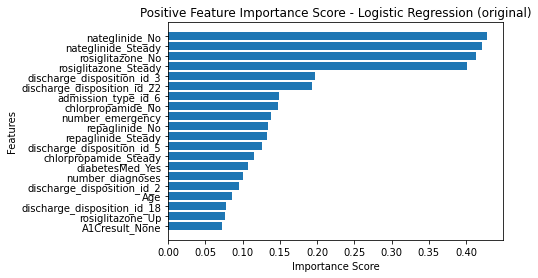

In [18]:
# Plot the feature importances from the logistic regression model
# Extract importances from the fitted model
ft_imprtnc = pd.DataFrame(mdl.coef_[0], index = X.columns, columns=['importance'])
ft_imprtnc = ft_imprtnc.sort_values('importance',ascending=False)

# Set number of top features to consider
num = 20
ylocs = np.arange(num)

# Get the top positive feature importances and sort in reverse order
vals = ft_imprtnc.iloc[:num].values.ravel()[::-1]
ft_lbls = list(ft_imprtnc.iloc[:num].index)[::-1]

# Plot
plt.figure();
plt.barh(ylocs, vals, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression (original)')
plt.yticks(ylocs, ft_lbls)
plt.show()

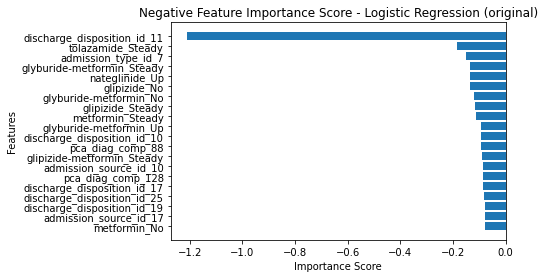

In [19]:
# Plot the negative importances
vals = ft_imprtnc.iloc[-num:].values.ravel()
ft_lbls = list(ft_imprtnc.iloc[-num:].index)

# Plot
plt.figure();
plt.barh(ylocs, vals, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression (original)')
plt.yticks(ylocs, ft_lbls)
plt.show()

### Uh oh! Looking back at the IDs_mapping document, I found that "Discharge disposition id 11" codes for "Expired"... Of course, you can't be readmitted if you *die* at the hospital (explaining the extreme importance score), so best to remove that (and several other related ids) from the model. 

### Let's remove those now and then train a new model

In [20]:
# Train new model
# First, drop death-related id codes
X2 = X.copy()
X2 = X2.drop(['discharge_disposition_id_11','discharge_disposition_id_19','discharge_disposition_id_20'],axis=1)

# Split data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X2, y, random_state = 3, test_size = 0.1)

# Train model
mdl = LogisticRegression(max_iter=200,class_weight=weights)
mdl.fit(X_train, y_train)

LogisticRegression(class_weight={0: 1.0764136602399121, 1: 14.086665353555247},
                   max_iter=200)

### Plot feature importances

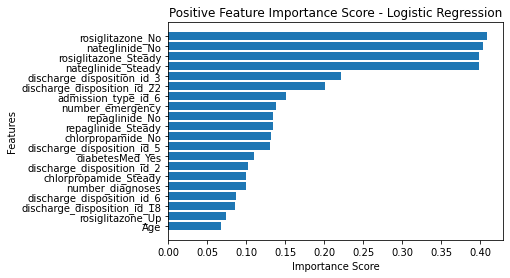

In [21]:
# Plot thefeature importances from the logistic regression model
# Extract importances from the fitted model
ft_imprtnc = pd.DataFrame(mdl.coef_[0], index = X2.columns, columns=['importance'])
ft_imprtnc = ft_imprtnc.sort_values('importance',ascending=False)

# Set number of top features to consider
num = 20
ylocs = np.arange(num)

# Get the top positive feature importances and sort in reverse order
vals = ft_imprtnc.iloc[:num].values.ravel()[::-1]
ft_lbls = list(ft_imprtnc.iloc[:num].index)[::-1]

# Plot
plt.figure();
plt.barh(ylocs, vals)
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Positive Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, ft_lbls)
plt.show()

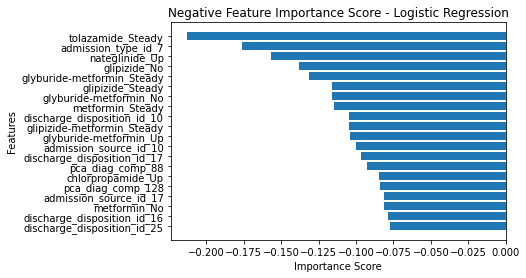

In [22]:
# Plot the negative importances
vals = ft_imprtnc.iloc[-num:].values.ravel()
ft_lbls = list(ft_imprtnc.iloc[-num:].index)

# Plot
plt.figure();
plt.barh(ylocs, vals)
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Negative Feature Importance Score - Logistic Regression')
plt.yticks(ylocs, ft_lbls)
plt.show()

### That looks better! The important features seem to make sense, e.g., patients with more emergency room visits have a higher readmission risk and patients on metformin-based drugs (usually for mild to moderate cases) are at lower readmission risk. Interestingly, nateglinide appears on both lists, such that increasing delivery of that drug may help reduce readmission risk. These features, however, will be best interpreted by domain experts. 

### Now, we will evaluate the model's performance.

### 2.2 Evaluate your model.

                precision    recall  f1-score   support

Not Readmitted       0.95      0.65      0.78      6627
    Readmitted       0.12      0.61      0.20       525

      accuracy                           0.65      7152
     macro avg       0.54      0.63      0.49      7152
  weighted avg       0.89      0.65      0.73      7152



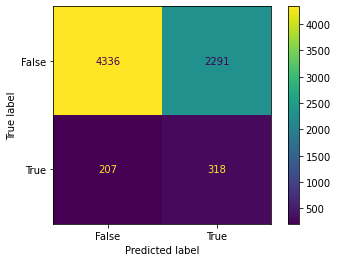

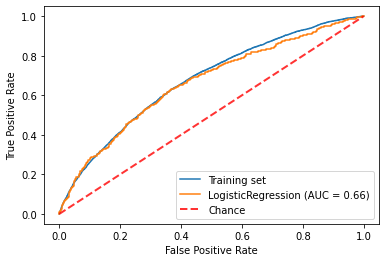

In [23]:
# Get predictions for test set
y_pred = mdl.predict(X_test)

# Print important metrics and plot confusion matrix
print(classification_report(y_test, y_pred, target_names=["Not Readmitted","Readmitted"]))
disp = plot_confusion_matrix(mdl, X_test, y_test)
plt.show()

# Plot ROC curves for training and testing sets
fig, ax = plt.subplots()
plot_roc_curve(mdl, X2, y, ax=ax, label='Training set')
plot_roc_curve(mdl, X_test, y_test, ax=ax)
ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
ax.legend()
plt.show()


### The primary results of the classification model are presented above. Importantly, we focus on the precision and recall values, because overall accuracy is not useful in the case of imbalanced datasets. The true/false positive (and negative) rates are depicted in the confusion matrix. We see that for the readmitted patients, we are able to correctly predict ~61% of cases (i.e. true-positives), suggesting that our model provides improved sensitivity over random guessing. However, of those we predicted to readmit, only ~12% actually readmitted, indicating that our model is not very specific. Finally, we see that the ROC curves are nearly identical between training and testing sets, suggesting that we are certainly not overfitting the data, but possibly are underfitting (indicating that increasing model complexity may help). The AUC value is useful for understanding how much better our model is than chance (see letter to owner below).  

### Future directions for this dataset could include:
1. Additional feature engineering focusing on some important aspects from the current results may improve the model, e.g., gathering more specifics about the type of skilled nursing or rehab facility a patient enters (given discharge ids 3 & 22 relate to higher risk). Also, predicting time-to-readmission as a continuous measure may be more powerful at determining the degree of risk, compared to a simple binary indicator of <30 days or not.  

2. More sophisticated classification algorithms (e.g. random forests or gradient boosting) with hyperparameter grid search to determine optimal settings may provide some incremental gains in performance.

---

## Part 3 – Communicate findings
### The business owner sends you an email asking for an update on the project. What is your response?

*Dear business owner,*

*Thank you for reaching out. I am pleased to inform you that we have built a working model for predicting a new patient's readmission risk. Using this model, our ability to distinguish between a high and low risk patient improved from 50/50 chance to a 66% success rate. This indicates our model will improve your sensitivity in detecting high risk patients. There does, however, remain a fairly high rate of false-positives. I would like to set up a meeting to review these results in more detail, and ensure the outcome will be satisfactory for your operational needs. We would further like discuss the feasibility of adding several more variables to this database, to supplement the most important variables indicated by our modeling.*  

*Please let me know your availability, and if you have any questions. I look forward to hearing from you.*


*Sincerely,*

*Benjamin Conrad, PhD, HCA Healthcare*